In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Kalibracja pojedynczej kamery

In [8]:
def get_points(left=True, show=True):
    # termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    # inner size of chessboard
    width = 9
    height = 6
    square_size = 0.025
    
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,6,0)
    objp = np.zeros((height * width, 1, 3), np.float64)
    objp[:, 0, :2] = np.mgrid[0:width, 0:height].T.reshape(-1, 2)

    objp = objp * square_size # Create real world coords. Use your metric.

    # Arrays to store object points and image points from all the images.
    objpoints = []  # 3d point in real world space
    imgpoints = []  # 2d points in image plane.

    img_width = 640
    img_height = 480
    image_size = (img_width, img_height)

    path = "mats/"
    image_dir = path + "pairs/"

    number_of_images = 50
    for i in range(1, number_of_images):
        # read image
        if left:
            img = cv2.imread(image_dir + "left_%02d.png" % i)
        else:
            img = cv2.imread(image_dir + "right_%02d.png" % i)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chess board corners
        ret, corners = cv2.findChessboardCorners(gray, (width, height), cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)

        Y, X, channels = img.shape

        # skip images where the corners of the chessboard are too close to the edges of the image
        if (ret == True):
            minRx = corners[:,:,0].min()
            maxRx = corners[:,:,0].max()
            minRy = corners[:,:,1].min()
            maxRy = corners[:,:,1].max()

            border_threshold_x = X/12
            border_threshold_y = Y/12

            x_thresh_bad = False
            if (minRx < border_threshold_x):
                x_thresh_bad = True

            if (maxRx > X - border_threshold_x):
                x_thresh_bad = True
            
            y_thresh_bad = False
            if (minRy < border_threshold_y):
                y_thresh_bad = True

            if (maxRy > Y - border_threshold_y):
                y_thresh_bad = True

            if (y_thresh_bad or x_thresh_bad):
                continue
        # If found, add object points, image points (after refining them)
        if ret == True:
            objpoints.append(objp)

            corners2 = cv2.cornerSubPix(gray, corners, (3, 3), (-1, -1), criteria)
            imgpoints.append(corners2)

            # Draw and display the corners
            if show:
                img = cv2.drawChessboardCorners(img, (width, height), corners2, ret)
                cv2.imshow('img', img)
                cv2.waitKey(500)
        else:
            print("Chessboard couldn't be detected. Image pair: " + str(i))
            continue
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return objpoints, imgpoints, image_size

In [9]:
def calibrate_camera(objpoints, imgpoints, image_size):
    calibration_flags = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC + cv2.fisheye.CALIB_FIX_SKEW
    N_OK = len(objpoints)
    K = np.zeros((3, 3))
    D = np.zeros((4, 1))
    rvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
    tvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]

    ret, K, D, _, _ = \
        cv2.fisheye.calibrate(
            objpoints,
            imgpoints,
            image_size,
            K,
            D,
            rvecs,
            tvecs,
            calibration_flags,
            (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6)
        )
    # Let's rectify our results
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), K, image_size, cv2.CV_16SC2)
    return K, D, map1, map2

In [10]:
K, D, map1, map2 = calibrate_camera(*get_points())

Chessboard couldn't be detected. Image pair: 30


In [11]:
number_of_images = 50
image_dir = "mats/pairs/"

for i in range(1, number_of_images):
    img = cv2.imread(image_dir + "left_%02d.png" % i)
    undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
    cv2.imshow('original', img)
    cv2.imshow('undistorted', undistorted_img)
    cv2.waitKey(100)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Kalibracja układu kamer

In [12]:
def get_points_pair(show=True):
    # termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    # inner size of chessboard
    width = 9
    height = 6
    square_size = 0.025
    
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,6,0)
    objp = np.zeros((height * width, 1, 3), np.float64)
    objp[:, 0, :2] = np.mgrid[0:width, 0:height].T.reshape(-1, 2)

    objp = objp * square_size # Create real world coords. Use your metric.

    # Arrays to store object points and image points from all the images.
    objpoints = []  # 3d point in real world space
    imgpointsLeft = []  # 2d points in image plane.
    imgpointsRight = []

    img_width = 640
    img_height = 480
    image_size = (img_width, img_height)

    path = "./mats/"
    image_dir = path + "pairs/"

    number_of_images = 50
    for i in range(1, number_of_images):
        imgLeft = cv2.imread(image_dir + "left_%02d.png" % i)
        imgRight = cv2.imread(image_dir + "right_%02d.png" % i)

        grayLeft = cv2.cvtColor(imgLeft, cv2.COLOR_BGR2GRAY)
        grayRight = cv2.cvtColor(imgRight, cv2.COLOR_BGR2GRAY)

        # Find the chess board corners
        retLeft, cornersLeft = cv2.findChessboardCorners(grayLeft, (width, height), cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)
        retRight, cornersRight = cv2.findChessboardCorners(grayRight, (width, height), cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)

        if (retLeft == True and retRight == True):
            objpoints.append(objp)

            cornersLeft2 = cv2.cornerSubPix(grayLeft, cornersLeft, (3, 3), (-1, -1), criteria)
            cornersRight2 = cv2.cornerSubPix(grayRight, cornersRight, (3, 3), (-1, -1), criteria)

            imgpointsLeft.append(cornersLeft2)
            imgpointsRight.append(cornersRight2)

            # Draw and display the corners
            if show:
                cv2.drawChessboardCorners(imgLeft, (width, height), cornersLeft2, retLeft)
                cv2.drawChessboardCorners(imgRight, (width, height), cornersRight2, retRight)
                cv2.imshow('imgLeft', imgLeft)
                cv2.imshow('imgRight', imgRight)
                cv2.waitKey(1)
        else:
            print("Chessboard couldn't be detected. Image pair: " + str(i))
            continue
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return objpoints, imgpointsLeft, imgpointsRight

In [13]:
def calc_maps_pair(objpoints, imgpointsLeft, imgpointsRight, image_size):
    K_left, D_left, map1_left, map2_left = calibrate_camera(objpoints, imgpointsLeft, image_size)
    K_right, D_right, map1_right, map2_right = calibrate_camera(objpoints, imgpointsRight, image_size)

    imgpointsLeft = np.asarray(imgpointsLeft, dtype=np.float64)
    imgpointsRight = np.asarray(imgpointsRight, dtype=np.float64)

    (RMS, _, _, _, _, rotationMatrix, translationVector) = cv2.fisheye.stereoCalibrate(
        objpoints, imgpointsLeft, imgpointsRight,
        K_left, D_left,
        K_right, D_right,
        image_size, None, None,
        cv2.CALIB_FIX_INTRINSIC,
        (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.01))

    R2 = np.zeros([3,3])
    P1 = np.zeros([3,4])
    P2 = np.zeros([3,4])
    Q = np.zeros([4,4])

    # Rectify calibration results
    (leftRectification, rightRectification, leftProjection, rightProjection,
    dispartityToDepthMap) = cv2.fisheye.stereoRectify(
        K_left, D_left,
        K_right, D_right,
        image_size,
        rotationMatrix, translationVector,
        0, R2, P1, P2, Q,
        cv2.CALIB_ZERO_DISPARITY, (0, 0), 0, 0)

    map1_left, map2_left = cv2.fisheye.initUndistortRectifyMap(
        K_left, D_left, leftRectification,
        leftProjection, image_size, cv2.CV_16SC2)

    map1_right, map2_right = cv2.fisheye.initUndistortRectifyMap(
        K_right, D_right, rightRectification,
        rightProjection, image_size, cv2.CV_16SC2)
    
    return map1_left, map2_left, map1_right, map2_right, Q


In [14]:
def calibrate_pair(img_l, img_r, show=True):
    image_size = img_l.shape[::-1][1:3]
    objpoints, imgpointsLeft, imgpointsRight = get_points_pair(show=False)
    map1_left, map2_left, map1_right, map2_right, Q = calc_maps_pair(objpoints, imgpointsLeft, imgpointsRight, image_size)

    dst_L = cv2.remap(img_l, map1_left, map2_left, cv2.INTER_LINEAR)
    dst_R = cv2.remap(img_r, map1_right, map2_right, cv2.INTER_LINEAR)

    N, XX, YY = dst_L.shape[::-1] # RGB image size

    visRectify = np.zeros((YY, XX*2, N), np.uint8) # Create a new image with a new size (height, 2*width)
    visRectify[:, 0:XX:,:] = dst_L # left image assignment
    visRectify[:,XX:XX*2:,:] = dst_R # right image assignment

    # draw horizontal lines
    if show:
        for y in range(0,YY,10):
            cv2.line(visRectify, (0,y), (XX*2,y), (255,0,0))
        cv2.imshow('rectified', visRectify)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    return dst_L, dst_R, Q

In [15]:
image_dir = "./mats/pairs/"
img_l = cv2.imread(image_dir + "left_01.png")
img_r = cv2.imread(image_dir + "right_01.png")

calibrate_pair(img_l, img_r)

Chessboard couldn't be detected. Image pair: 30


(array([[[170, 170, 170],
         [170, 170, 170],
         [170, 170, 170],
         ...,
         [210, 210, 210],
         [211, 211, 211],
         [211, 211, 211]],
 
        [[171, 171, 171],
         [170, 170, 170],
         [170, 170, 170],
         ...,
         [207, 207, 207],
         [207, 207, 207],
         [207, 207, 207]],
 
        [[172, 172, 172],
         [171, 171, 171],
         [171, 171, 171],
         ...,
         [209, 209, 209],
         [212, 212, 212],
         [210, 210, 210]],
 
        ...,
 
        [[ 60,  60,  60],
         [ 55,  55,  55],
         [ 47,  47,  47],
         ...,
         [ 39,  39,  39],
         [ 40,  40,  40],
         [ 41,  41,  41]],
 
        [[ 59,  59,  59],
         [ 51,  51,  51],
         [ 44,  44,  44],
         ...,
         [ 39,  39,  39],
         [ 39,  39,  39],
         [ 40,  40,  40]],
 
        [[ 56,  56,  56],
         [ 48,  48,  48],
         [ 43,  43,  43],
         ...,
         [ 39,  39,  39],
  

# Obliczenia korespondencji stereo

In [16]:
# Load images
img = cv2.imread("./mats/example/example0.jpg")
img_size = img.shape
imgLeft = img[:, 0:int(img_size[1]/2), :]
imgRight = img[:, int(img_size[1]/2):img_size[1], :]

# resize to 680x480
imgLeft = cv2.resize(imgLeft, (640, 480))
imgRight = cv2.resize(imgRight, (640, 480))

imgLeftCalibrated, imgRightCalibrated, _ = calibrate_pair(imgLeft, imgRight, show=False)

Chessboard couldn't be detected. Image pair: 30


In [17]:
stereo = cv2.StereoBM_create(
    numDisparities=96, 
    blockSize=15,
    )
disparity = stereo.compute(cv2.cvtColor(imgLeft, cv2.COLOR_BGR2GRAY), cv2.cvtColor(imgRight, cv2.COLOR_BGR2GRAY))
disparityCalibrated = stereo.compute(cv2.cvtColor(imgLeftCalibrated, cv2.COLOR_BGR2GRAY), cv2.cvtColor(imgRightCalibrated, cv2.COLOR_BGR2GRAY))

In [18]:
# Semi Global Matching
window_size = 6
min_disp = 16
num_disp = 112 - min_disp
stereo = cv2.StereoSGBM_create(
    minDisparity=min_disp,
    numDisparities=num_disp,
    blockSize=4,
    P1=8 * 3 * window_size ** 2,
    P2=32 * 3 * window_size ** 2,
    disp12MaxDiff=1,
    uniquenessRatio=10,
    speckleWindowSize=100,
    speckleRange=32
    )

sgm = stereo.compute(imgLeft, imgRight).astype(np.float32) / 16.0
sgmCalibrated = stereo.compute(imgLeftCalibrated, imgRightCalibrated).astype(np.float32) / 16.0

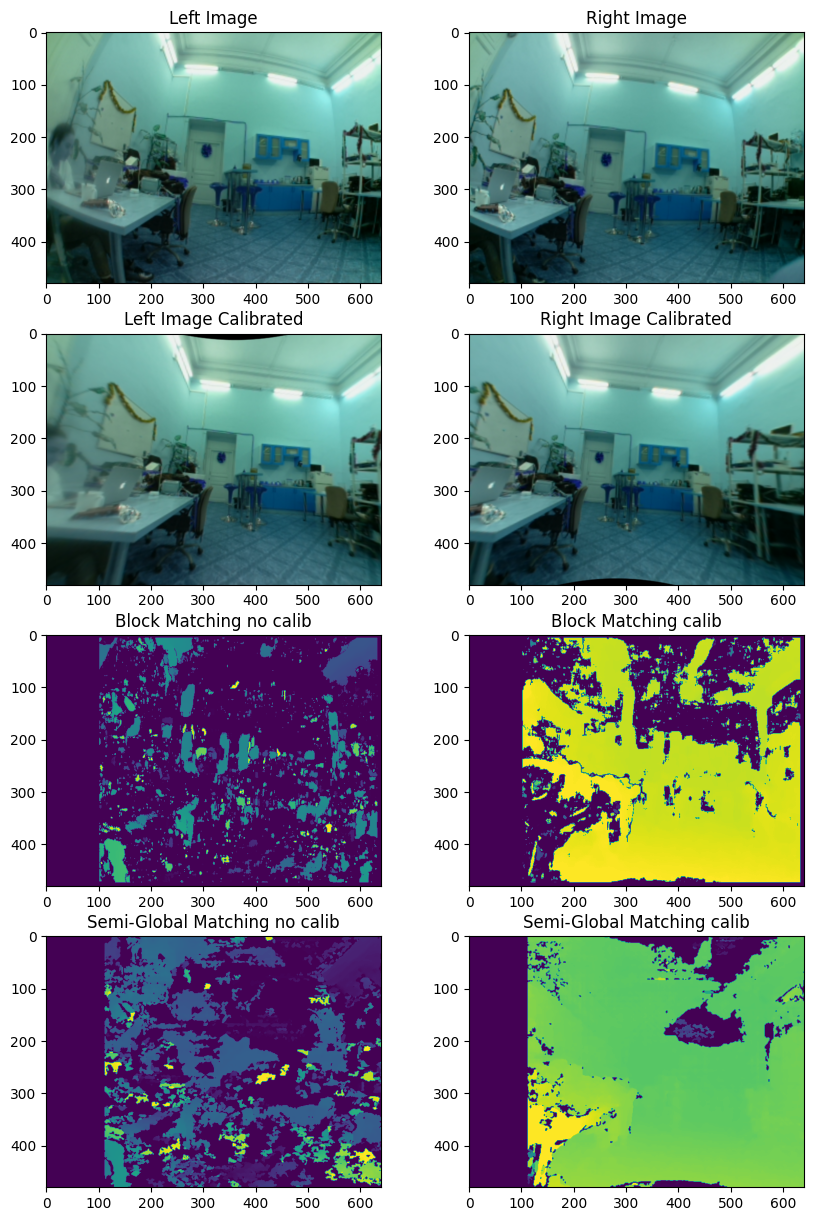

In [20]:
plt.subplots(4, 2, figsize=(10, 15))
plt.subplot(421)
plt.imshow(imgLeft)
plt.title('Left Image')
plt.subplot(422)
plt.imshow(imgRight)
plt.title('Right Image')
plt.subplot(423)
plt.imshow(imgLeftCalibrated)
plt.title('Left Image Calibrated')
plt.subplot(424)
plt.imshow(imgRightCalibrated)
plt.title('Right Image Calibrated')
plt.subplot(425)
plt.imshow(disparity)
plt.title('Block Matching no calib')
plt.subplot(426)
plt.imshow(disparityCalibrated)
plt.title('Block Matching calib')
plt.subplot(427)
plt.imshow(sgm)
plt.title('Semi-Global Matching no calib')
plt.subplot(428)
plt.imshow(sgmCalibrated)
plt.title('Semi-Global Matching calib')
plt.show()
